<a href="https://www.kaggle.com/code/lonnieqin/natural-language-inference-with-distilbert?scriptVersionId=114506941" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Natural Language Inference with DistilBert

In [1]:
import numpy as np
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import gc

2022-12-22 16:10:07.512695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Distribution Strategy

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Configuration

In [3]:
class CFG:
    batch_size = strategy.num_replicas_in_sync * 16
    sequence_length = 128
    is_training = False
    add_external_dataset = True

## Load data

In [4]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


## Load Pretrained model

In [5]:
with strategy.scope():
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoder = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    gc.collect()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

2022-12-22 16:10:26.974043: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-22 16:10:26.978398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-22 16:10:27.052733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 16:10:27.053586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-22 16:10:27.053667: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-22 16:10:27.084812: I tensorflow/stream_executor/platform/def

In [6]:
encoder.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


Let's learn about this pretrained model's input and output. When we past a text list to this pretrained model, it returns a dictionary with  key last_hidden_state.

In [7]:
texts = ["hello world.", "how are you doing?"]
text_preprocessed = tokenizer(
    texts, 
    max_length = CFG.sequence_length,
    truncation=True, 
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)
print(text_preprocessed)
output = encoder(text_preprocessed)
output

{'input_ids': <tf.Tensor: shape=(2, 128), dtype=int32, numpy=
array([[ 101, 7592, 2088, 1012,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 101, 2129, 2024, 2017, 2725, 1029,  102,    0,    0,    0,    0,

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 128, 768), dtype=float32, numpy=
array([[[-0.13655967, -0.19456   ,  0.06066157, ..., -0.159869  ,
          0.3002973 ,  0.38104224],
        [-0.31335434,  0.08432113,  0.5446054 , ..., -0.13485643,
          0.73305535,  0.47490847],
        [ 0.0154313 ,  0.08995689,  0.77681524, ..., -0.04456286,
          0.3383794 ,  0.20973638],
        ...,
        [-0.19495487,  0.20163043,  0.69072133, ..., -0.00997185,
          0.17069551,  0.15956454],
        [-0.12937203,  0.13508472,  0.4856619 , ..., -0.01744056,
          0.07100698,  0.1052727 ],
        [-0.18860874, -0.15029146,  0.32085568, ...,  0.17644373,
          0.01106421,  0.09787831]],

       [[-0.05056342, -0.03165476, -0.01177493, ..., -0.05328222,
          0.33551887,  0.23956566],
        [ 0.10443099, -0.16184655, -0.28821135, ..., -0.08709944,
          0.297112  , -0.19777445],
        [ 0.440349  , -0.30774304,  0.11389706, ..., -0.78932595,
          0.

## Text Preprocessing

In [8]:
def preprocess_data(df):
    df["text"] = "[CLS] " + df["premise"] + " [SEP] " + df["hypothesis"] + " [SEP]"
    return df

In [9]:
%%time
train = preprocess_data(train)
train.head()

CPU times: user 14.8 ms, sys: 6.71 ms, total: 21.5 ms
Wall time: 28.1 ms


,id,premise,hypothesis,lang_abv,language,label,text
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[CLS] and these comments were considered in fo...
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[CLS] These are issues that we wrestle with in...
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0,[CLS] Des petites choses comme celles-là font ...
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[CLS] you know they can't really defend themse...
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1,[CLS] ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะ...


## 

## Load MNLI dataset
You can learn more about this dataset [here](https://huggingface.co/datasets/multi_nli).

In [10]:
def load_mnli(use_validation=True):
    result=[]
    dataset=load_dataset('multi_nli')
    print(dataset)
    for record in dataset['train']:
        c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
        if c1 and c2 and c3 in {0, 1, 2}:
            result.append((c1, c2, c3, 'en'))
    result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    return result

In [11]:
mnli = load_mnli()
mnli.head()

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en


In [12]:
mnli = preprocess_data(mnli)
mnli.head()

,premise,hypothesis,label,lang_abv,text
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en,[CLS] Conceptually cream skimming has two basi...
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en,[CLS] you know during the season and i guess a...
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en,[CLS] One of our number will carry out your in...
3,How do you know? All this is their information...,This information belongs to them.,0,en,[CLS] How do you know? All this is their infor...
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en,[CLS] yeah i tell you what though if you go pr...


## Create TensorFlow Dataset

In [13]:
def bert_encode(df, tokenizer):    
    texts = df['text'].tolist()
    tokens = tokenizer(
        texts, 
        max_length = CFG.sequence_length,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    if "label" in df.keys():
        tokens["label"] = df["label"]
    return tokens

def preprocess(features):
    input_ids = features.pop("input_ids")
    attention_mask = features.pop("attention_mask")
    labels = features.pop("label")
    return (input_ids, attention_mask), labels
def make_dataset(df, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices((df))
    if mode == "train":
        ds = ds.shuffle(256)
    ds = ds.batch(CFG.batch_size)
    ds = ds.map(preprocess)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE).repeat()
    return ds

In [14]:
%%time
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=2)
if CFG.add_external_dataset:
    train_data=pd.concat([train_data, mnli.loc[:100000]], axis=0)
    train_data.head()

CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 41.7 ms


In [15]:
%%time
train_input = bert_encode(train_data, tokenizer)
valid_input = bert_encode(valid_data, tokenizer)
train_ds = make_dataset(train_input)
valid_ds = make_dataset(valid_input, mode="valid")

CPU times: user 1min 48s, sys: 476 ms, total: 1min 49s
Wall time: 1min 50s


Take a look at what training data looks like.

In [16]:
for item in train_ds.take(1):
    print(item)

((<tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  101,   101,  2085, ...,     0,     0,     0],
       [  101,   101,  1005, ..., 29836, 29843,   102],
       [  101,   101, 10722, ...,     0,     0,     0],
       ...,
       [  101,   101,  1298, ...,     0,     0,     0],
       [  101,   101,  2358, ...,     0,     0,     0],
       [  101,   101,  9308, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>), <tf.Tensor: shape=(16,), dtype=int64, numpy=array([0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2])>)


2022-12-22 16:14:03.130521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-22 16:14:03.136113: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz
2022-12-22 16:14:03.164801: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Calcuate class weight

The dataset is relatively balanced. However I would like to add class_weight parameter in keras training method. In this way we often can improve the score a little bit.

<AxesSubplot:>

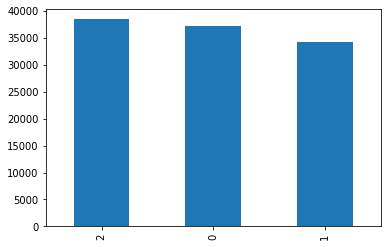

In [17]:
train_data["label"].value_counts().plot(kind="bar")

In [18]:
class_weight = len(train_data["label"]) / train_data["label"].value_counts()
class_weight = dict(class_weight / class_weight.sum())
class_weight

{2: 0.3165196686886762, 0: 0.32727167595322115, 1: 0.3562086553581027}

## Building Model

In [19]:
def build_model():
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")
    inputs = [input_ids, attention_mask]
    embedding = encoder(inputs)["last_hidden_state"]
    vector = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    vector = tf.keras.layers.Dropout(0.3)(vector)
    output = tf.keras.layers.Dense(3, activation='softmax')(vector)
      
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return model 

In [20]:
with strategy.scope():
    model = build_model()
    model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model[0][0]   

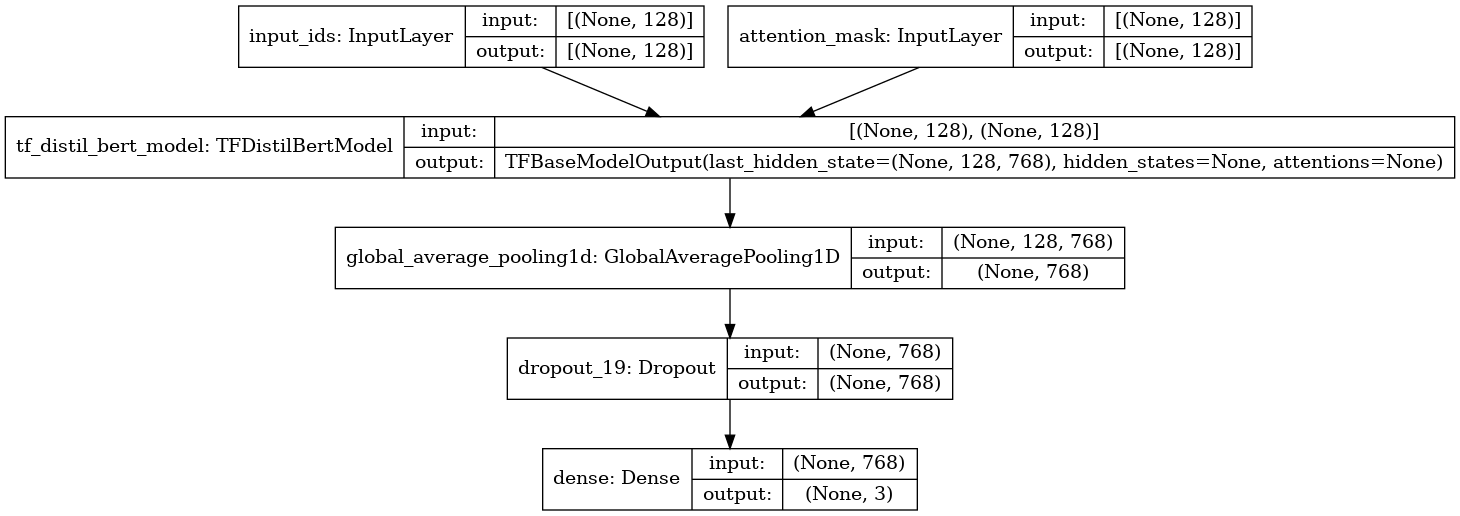

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training Model
When I train the Model using TPU and and try to save the whole model, error occurs. I solve this issue by saving weights only and save to h5 format. Training model on GPU doesn't have such issue.

In [22]:
with strategy.scope():
    if CFG.is_training:
        steps_per_epoch = train_data.shape[0] // CFG.batch_size
        validation_steps = valid_data.shape[0] // CFG.batch_size
        es = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            "model.h5", 
            monitor="val_accuracy", 
            save_best_only=True, 
            save_weights_only=True, 
            restore_best_weights=True
        )
        history = model.fit(
            train_ds, 
            epochs = 20, 
            steps_per_epoch = steps_per_epoch,
            validation_steps = validation_steps,
            validation_data=valid_ds,
            class_weight=class_weight,
            callbacks=[es, checkpoint]
        )
        pd.DataFrame(history.history).plot()
    else:
        model.load_weights("../input/nli-distilbert/model.h5")

## Create Submission file

In [23]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test = preprocess_data(test)
test_input = bert_encode(test, tokenizer)
test_ds = tf.data.Dataset.from_tensor_slices(
    (
        (
            test_input["input_ids"], 
            test_input["attention_mask"]
        ), 
        np.zeros(len(test))
    )
).batch(128)
predictions = np.argmax(model.predict(test_ds), axis=1)
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.to_csv("submission.csv", index = False)
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0
